In [ ]:
import pandas as pd
import pandas as pd
import math
import numpy as np

def parse_file(file_path):
    cells_started = False
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    nodes = {}
    edges = {}
    cellss={}
    current_section = None
    for line in lines:
        line = line.strip()
        if not line:  # If the line is empty, reset the current section
            current_section = None
        elif "BEGIN_" in line:
            if "BEGIN_NODES" in line:
                current_section = "nodes"
            elif "BEGIN_EDGEGROUPS" in line:
                current_section = "edges"
            elif "BEGIN_ELEMENTS" in line:
                current_section = "cells"
        elif current_section:
            parts = line.split('\t')
            if current_section == "nodes":
                node_id = int(parts[0])
                if node_id != 0:  # Excluding nodes with ID 0
                    x_pos = float(parts[1])
                    y_pos = float(parts[2])
                    nodes[node_id] = (x_pos, -y_pos)
            elif current_section == "edges":
                edge_id = int(parts[0])
                if edge_id < 1000:  # Excluding edges with ID above 1000
                    node_1 = int(parts[1].split()[0])  # Parsing only the first node
                    node_2 = int(parts[1].split()[1])  # Parsing only the second node 
                    
                    cell_1 = int(parts[2].split()[0])  # Parsing the x position of the edge midpoint
                    cell_2 = int(parts[2].split()[1])  # Parsing the y position of the edge midpoint
                    
                    mid_x_pos = float(parts[3].split()[1])  # Parsing the x position of the edge midpoint
                    mid_y_pos = -float(parts[3].split()[2])  # Parsing the y position of the edge midpoint
                    edges[edge_id] = (node_1, node_2, mid_x_pos, mid_y_pos, cell_1, cell_2)
                    
            elif current_section == "cells":
                
                if not line.startswith(' '):
                    cells = parts[0]
                    if cells.isdigit():  # Comprobamos si el primer elemento de la línea es un número
                        cells = int(cells)  # Convertimos la cadena en un entero
                        if cells == 2:  # Comprobamos si cells es igual o mayor a 2
                            cells_started = True  # Comenzamos a procesar las celdas

                if cells_started:
                    cells = parts[0]
                    if cells.isdigit():# Solo procesamos las líneas si hemos empezado a procesar las celdas
                        if len(parts) > 11:  # Nos aseguramos de que parts[11] existe para evitar errores
                            Area= float(parts[11].split()[0])
                            cellss[int(cells)]=Area        


    # Create dataframe
    data = []
    for edge_id, (node_1, node_2, mid_x_pos, mid_y_pos,  cell_1, cell_2) in edges.items():
        if node_1 in nodes and node_2 in nodes:
            x1, y1 = nodes[node_1]
            x2, y2 = nodes[node_2]
            vector = np.array([x2-x1, y2-y1])
            length = np.linalg.norm(vector)
            angle = math.degrees(math.atan2(y2-y1, x2-x1))
            angle = abs(angle)  # get the absolute value
            angle = 180 - angle if angle > 180 else angle  # adjust if angle > 180
            data.append([edge_id, x1, y1, x2, y2,  length, mid_x_pos, mid_y_pos, vector, angle,  cell_1, cell_2])

    df = pd.DataFrame(data, columns=['EdgeID', 'X1', 'Y1', 'X2', 'Y2', 'Length','Mid_X', 'Mid_Y', 'Vector', 'Angle', 'CELL1', 'CELL2'])
    
    df['Area_CELL1'] = df['CELL1'].map(cellss).fillna(0)  # map cell's ID to its area
    df['Area_CELL2'] = df['CELL2'].map(cellss).fillna(0)  # map cell's ID to its area
    # Load tension data
    tension_data = pd.read_csv(r"C:\Users\Jon\Desktop\TODAVIA POR CAMBIAR\Meshes\Mesh149\franjas_Output.csv", usecols=["EdgeID", "Tension", "stdError"])
    #tension_data = pd.read_csv(r"C:\Users\Jon\Documents\Master Biofísica\TFM\PELIS MOSCAS - ORIGINALES\22126 230523 c381ECadGFP\1-\Meshes\SILVESTRE 0\1- T=002_Output.csv", usecols=["EdgeID", "Tension", "stdError"])
    #tension_data = pd.read_csv(r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh074\POCA MIOS7_Output.csv", usecols=["EdgeID", "Tension"])
    #tension_data = pd.read_csv(r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh149\POCA MIOS8_Output.csv", usecols=["EdgeID", "Tension"])
    
    # Merge tension data with existing dataframe
    df = pd.merge(df, tension_data, on='EdgeID')
    
    return df

#PARA CELLS



file_path = r"C:\Users\Jon\Desktop\TODAVIA POR CAMBIAR\Meshes\Mesh149\franjas.txt"
#file_path = r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh074\POCA MIOS7.txt"
#file_path = r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh149\POCA MIOS8.txt"
df = parse_file(file_path)
print(df)


In [6]:
# Duplicamos el dataframe y renombramos las columnas de tal forma
# que podamos concatenarlos después
df1 = df[['CELL1', 'Area_CELL1', 'Tension', 'stdError']].copy()
df2 = df[['CELL2', 'Area_CELL2', 'Tension', 'stdError']].copy()

df1.columns = ['CELL', 'Area', 'Tension', 'stdError']
df2.columns = ['CELL', 'Area', 'Tension', 'stdError']

# Concatenamos los dataframes
df_concat = pd.concat([df1, df2])

# Agrupamos por CELL y calculamos el área (asumimos que el área es la misma para una celda dada)
# y la media de las tensiones y stdError.
df_final = df_concat.groupby('CELL').agg({'Area': 'first', 'Tension': np.mean, 'stdError': np.mean}).reset_index()

# Añadimos una nueva columna que es la relación entre la tensión y stdError
df_final['Tension/stdError'] = df_final['Tension'] / df_final['stdError']
df_final = df_final[df_final['Area'] != 0]


import matplotlib.pyplot as plt

# Gráfico de Tension/stdError vs Area
plt.figure(figsize=(10,6))
plt.scatter(df_final['Area'], df_final['Tension/stdError'])
plt.title('Tension/stdError vs Area')
plt.xlabel('Area')
plt.ylabel('Tension/stdError')
plt.show()


In [1]:
import seaborn as sns
from scipy import stats

# Configuración de los estilos del gráfico.
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# Creamos un scatterplot con una línea de regresión.
sns.regplot(x=df_final['Area'], y=df_final['Tension/stdError'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.title('Tension/stdError vs Area per Cell')
plt.xlabel('Area')
plt.ylabel('Tension/stdError Mean')

plt.show()

# Calculamos la correlación de Pearson y su valor-p
correlation, p_value = stats.pearsonr(df_final['Area'], df_final['Tension/stdError'])

print(f"Correlación de Pearson: {correlation}")
print(f"Valor-p: {p_value}")


NameError: name 'plt' is not defined

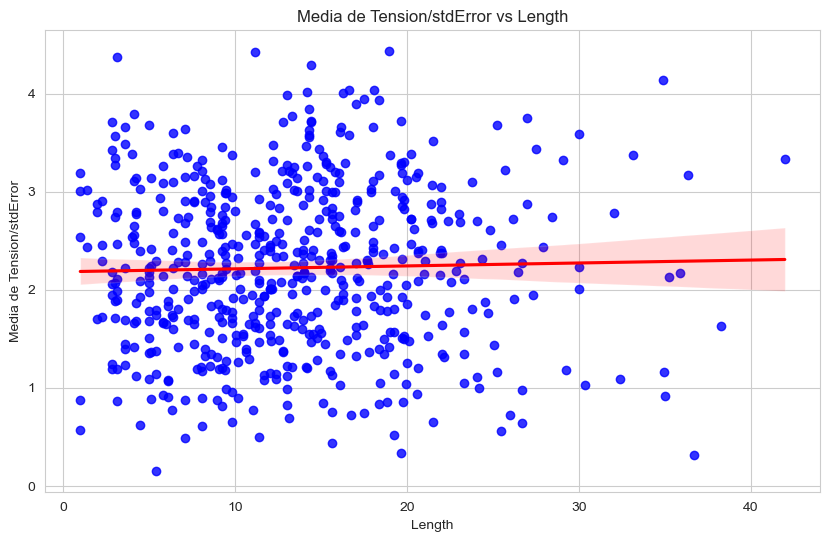

Correlación de Pearson: 0.02559400025753461
Valor-p: 0.535303164480512


In [4]:
# Calculamos Tension/stdError
df['Tension/stdError'] = df['Tension'] / df['stdError']

# Filtramos las filas con Length menor que 4
df_filtered = df[df['Length'] >= 1]
import seaborn as sns
from scipy import stats

# Configuración de los estilos del gráfico.
sns.set_style("whitegrid")

plt.figure(figsize=(10,6))

# Creamos un scatterplot con una línea de regresión.
sns.regplot(x=df_filtered['Length'], y=df_filtered['Tension/stdError'], scatter_kws={"color": "blue"}, line_kws={"color": "red"})

plt.title('Media de Tension/stdError vs Length')
plt.xlabel('Length')
plt.ylabel('Media de Tension/stdError')

plt.show()

# Calculamos la correlación de Pearson y su valor-p
correlation, p_value = stats.pearsonr(df_filtered['Length'], df_filtered['Tension/stdError'])

print(f"Correlación de Pearson: {correlation}")
print(f"Valor-p: {p_value}")


In [40]:
#BEGIN_ALLEDGES  PARAA DESPEUS PLOTEAR

In [7]:
# Duplicamos el dataframe y renombramos las columnas de tal forma
# que podamos concatenarlos después
df1 = df[['CELL1', 'Area_CELL1', 'Tension', 'stdError', 'X1', 'Y1']].copy()
df2 = df[['CELL2', 'Area_CELL2', 'Tension', 'stdError', 'X2', 'Y2']].copy()

df1.columns = ['CELL', 'Area', 'Tension', 'stdError', 'X', 'Y']
df2.columns = ['CELL', 'Area', 'Tension', 'stdError', 'X', 'Y']

# Concatenamos los dataframes
df_concat = pd.concat([df1, df2])

# Agrupamos por CELL y calculamos el área, la media de las tensiones, stdError, y las medias de X e Y.
df_final = df_concat.groupby('CELL').agg({'Area': 'first', 'Tension': np.mean, 'stdError': np.mean, 'X': np.mean, 'Y': np.mean}).reset_index()

# Añadimos una nueva columna que es la relación entre la tensión y stdError
df_final['Tension/stdError'] = df_final['Tension'] / df_final['stdError']


In [8]:
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np

class SelectFromImage(object):
    def __init__(self, ax, data):
        self.ax = ax
        self.data = data
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None
        self.verts = None

    def onselect(self, verts):
        self.verts = verts  # Guardar los vértices seleccionados
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        
        # Crear una columna para indicar si el centroide está dentro del área seleccionada
        self.data['In_Area'] = self.data.apply(lambda row: path.contains_point((row.X, row.Y)), axis=1)
        self.ax.figure.canvas.draw()


fig, ax = plt.subplots(figsize=(10, 10))

# Dibuja los nodos
ax.scatter(df_final['X'], df_final['Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    ax.plot([row['X1'], row['X2']], 
            [row['Y1'], row['Y2']],
            color='blue')

ax.set_title('Visualización del tejido')

lasso_select = SelectFromImage(ax, df_final)
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Configura el tamaño de la figura para que sea más ancha
df_inside = df_final[df_final['In_Area']]
df_outside = df_final[~df_final['In_Area']]

# Crea subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Ordena los dataframes por tensión
df_inside = df_inside.sort_values('Tension')
df_outside = df_outside.sort_values('Tension')

# Dibuja los puntos para los edges dentro del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_inside)), df_inside['Tension'], yerr=df_inside['stdError'], fmt='o', 
            color='blue', ecolor='black', elinewidth=1, capsize=3, label='AS/AS')

# Dibuja los puntos para los edges fuera del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_outside)), df_outside['Tension'], yerr=df_outside['stdError'], fmt='o', 
            color='red', ecolor='black', elinewidth=1, capsize=3, label='LE/LE')

# Añade una leyenda
ax.legend(fontsize=15)

# Añade títulos y etiquetas
#ax.set_title('Tension of Edges Inside and Outside Selected Area', fontsize=16)
ax.set_xlabel('Edge', fontsize=15)
ax.set_ylabel('Tension', fontsize=15)

# Ajusta el estilo de los ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Hace el eje x más largo
#ax.set_xlim(-1, max(len(df_inside), len(df_outside)))
#box_plot.tick_params(axis='x', labelsize=1)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()

NameError: name 'box_plot' is not defined

In [ ]:


import seaborn as sns
from scipy import stats

# Configura el estilo de los plots a 'whitegrid' para un mejor diseño
sns.set_style('whitegrid')

# Combina los dos dataframes en uno con una nueva columna 'Location' para indicar la ubicación de los edges
df_combined = pd.concat([df_outside.assign(Location='LE/LE'), df_inside.assign(Location='AS/AS')])

# Crea un boxplot con los puntos mostrados
plt.figure(figsize=(5, 5))
box_plot = sns.boxplot(x='Location', y='Tension', data=df_combined, palette='Set1')
sns.stripplot(x='Location', y='Tension', data=df_combined, 
              size=4, color='grey', alpha=0.6, )

# Establece los títulos y etiquetas
#box_plot.set_title('Boxplot of Tension Inside and Outside Selected Area', fontsize=16)
box_plot.set_xlabel('')
box_plot.set_ylabel('Tension', fontsize=15)

# Realiza un test t de Student para comparar las medias
t_stat, p_val = stats.ttest_ind(df_inside['Tension'], df_outside['Tension'], equal_var=False)

# Añade la anotación de significancia al gráfico
significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '.' if p_val < 0.1 else 'ns'

# Define la posición y longitud de la barra de significancia
y_max = max(df_inside['Tension'].max(), df_outside['Tension'].max())
h = y_max * 0.00  # 5% of the maximum y value
bar_start = 0.0
bar_end = 1

# Dibuja la barra de significancia
box_plot.plot([bar_start, bar_start, bar_end, bar_end], 
              [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
              lw=1.5, color='black')
# Añade la anotación
box_plot.text((bar_start + bar_end) / 2, y_max -0.05, 
              f"{significance_code}", 
              ha='center', va='bottom', color='black', fontsize=13)
box_plot.tick_params(axis='x', labelsize=15)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()


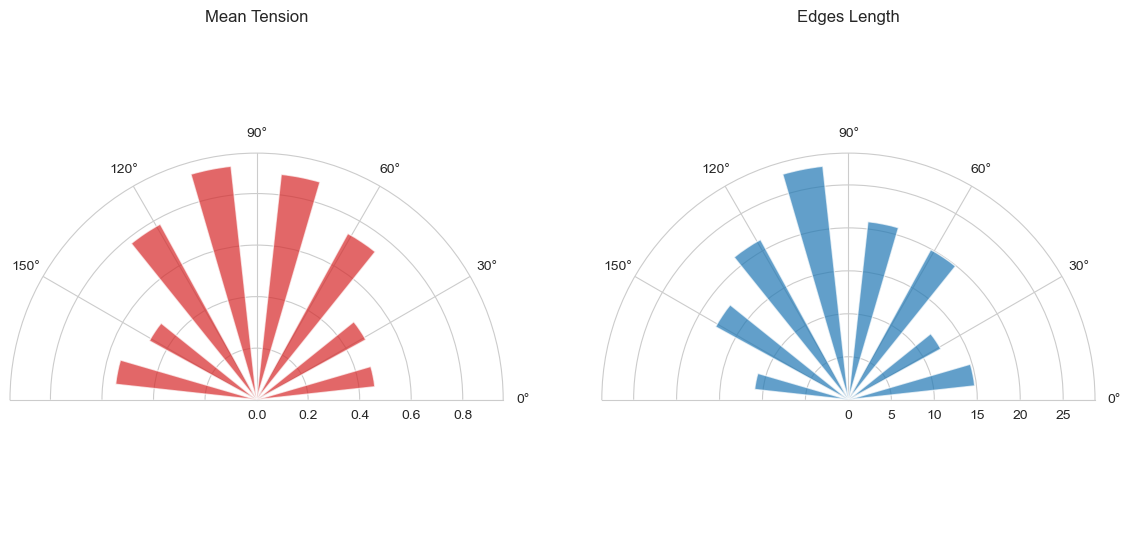

                    Tension_normalized  Length_normalized
Tension_normalized               1.000              0.846
Length_normalized                0.846              1.000


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the degree to radians for polar plot
bins = np.arange(0, 185, 22.5)
x_labels = (bins[:-1] + bins[1:]) / 2

df['Angle_bins'] = pd.cut(df['Angle'], bins)
#print(df)
bins_radians = np.deg2rad(x_labels)

# Group data by 'Angle_bins' and calculate mean 'Tension' and count 'EdgeID'
grouped = df.groupby('Angle_bins').agg({'Tension': 'median', 'Length': 'mean'})

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, polar=True)
bars = ax1.bar(bins_radians, grouped['Tension'], width=np.deg2rad(10), color='tab:red', alpha=0.7)
ax1.set_theta_zero_location("E")  
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax1.set_thetamin(0)
ax1.set_thetamax(180)
plt.title('Mean Tension')

ax2 = fig.add_subplot(122, polar=True)
bars = ax2.bar(bins_radians, grouped['Length'], width=np.deg2rad(10), color='tab:blue', alpha=0.7)
ax2.set_theta_zero_location("E")  
ax2.set_theta_direction(1)
ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax2.set_thetamin(0)
ax2.set_thetamax(180)
plt.title('Edges Length')

plt.show()

# First, we need to normalize the 'Tension' and 'EdgeID' columns by their maximum values
grouped['Tension_normalized'] = grouped['Tension'] / grouped['Tension'].max()
grouped['Length_normalized'] = grouped['Length'] / grouped['Length'].max()

# Now we calculate the correlation
correlation = grouped[['Tension_normalized', 'Length_normalized']].corr()

print(correlation)


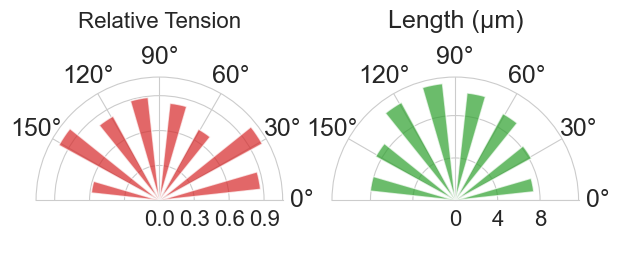

                    Tension_normalized  Length_normalized
Tension_normalized             1.00000            0.01709
Length_normalized              0.01709            1.00000


In [31]:
# Convert the degree to radians for polar plot
bins = np.arange(0, 185, 22.5)
x_labels = (bins[:-1] + bins[1:]) / 2
df['Angle_bins'] = pd.cut(df['Angle'], bins)
bins_radians = np.deg2rad(x_labels)

# Group data by 'Angle_bins'
grouped = df.groupby('Angle_bins').agg({'Tension': 'median', 'EdgeID': 'count', 'Length': 'mean'})
grouped['Length'] = grouped['Length'] / 1.762 

fig = plt.figure(figsize=(7,9))

ax1 = fig.add_subplot(121, polar=True)
bars = ax1.bar(bins_radians, grouped['Tension'], width=np.deg2rad(10), color='tab:red', alpha=0.7)
ax1.set_theta_zero_location("E")
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
ax1.set_thetamin(0)
ax1.set_thetamax(180)
ax1.text(np.pi/2, ax1.get_ylim()[1]*1.4, 'Relative Tension', fontsize=16, ha='center')

#ax2 = fig.add_subplot(122, polar=True)
#bars = ax2.bar(bins_radians, grouped['EdgeID'], width=np.deg2rad(10), color='tab:blue', alpha=0.7)
#ax2.set_theta_zero_location("E")
#ax2.set_theta_direction(1)
#ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
#ax2.set_thetamin(0)
#ax2.set_thetamax(180)
#ax2.text(np.pi/2, ax2.get_ylim()[1]*1.4, 'Number of Edges', fontsize=18, ha='center')

ax3 = fig.add_subplot(122, polar=True)
bars = ax3.bar(bins_radians, grouped['Length'], width=np.deg2rad(10), color='tab:green', alpha=0.7)
ax3.set_theta_zero_location("E")
ax3.set_theta_direction(1)
ax3.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))
ax3.set_thetamin(0)
ax3.set_thetamax(180)
ax3.text(np.pi/2, ax3.get_ylim()[1]*1.4, 'Length (\u03BCm)', fontsize=18, ha='center')

# Establece las marcas en el eje radial para la tensión
y_min_tension, y_max_tension = ax1.get_ylim()
ax1.set_yticks(np.arange(np.ceil(y_min_tension), y_max_tension, 0.3))

# Establece las marcas en el eje radial para la longitud
y_min_length, y_max_length = ax3.get_ylim()
ax3.set_yticks(np.arange(np.ceil(y_min_length), y_max_length, 4))

# Establece las marcas en el eje radial para la longitud
#y_min_length, y_max_length = ax2.get_ylim()
#ax2.set_yticks(np.arange(np.ceil(y_min_length), y_max_length, 40))

plt.setp(ax1.get_xticklabels(), fontsize=18)
#plt.setp(ax2.get_xticklabels(), fontsize=18)
plt.setp(ax3.get_xticklabels(), fontsize=18)


ax1.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el primer gráfico
#ax2.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el segundo gráfico
ax3.tick_params(axis='y', labelsize=16)  # Ajustar el tamaño de las marcas en el eje y para el tercer gráfico

# Obtén las ubicaciones y etiquetas actuales de las marcas en el eje radial
#y_ticks_tension = ax1.get_yticks()
#ax1.set_yticks(y_ticks_tension)
#radian_values = np.arange(np.ceil(y_min_tension), y_max_tension, 0.1)


y_ticks_length = ax3.get_yticks()
ax3.set_yticks(y_ticks_length)
ax3.set_yticklabels([int(tick) for tick in ax3.get_yticks()], fontsize=18)

#y_ticks_edgeid = ax2.get_yticks()
#ax2.set_yticks(y_ticks_edgeid)
#ax2.set_yticklabels([int(tick) for tick in ax2.get_yticks()], fontsize=18)

plt.subplots_adjust(hspace=0) 
plt.show()

# First, we need to normalize the 'Tension' and 'EdgeID' columns by their maximum values
grouped['Tension_normalized'] = grouped['Tension'] / grouped['Tension'].max()
grouped['Length_normalized'] = grouped['Length'] / grouped['Length'].max()

# Now we calculate the correlation
correlation = grouped[['Tension_normalized', 'Length_normalized']].corr()

print(correlation)

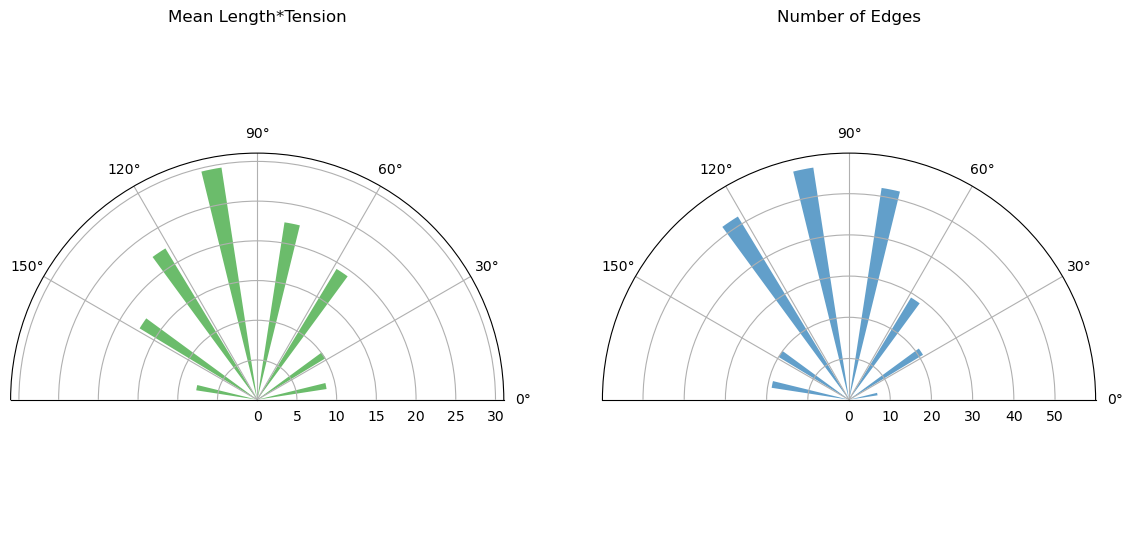

                    Tension_normalized  EdgeID_normalized
Tension_normalized            1.000000           0.898316
EdgeID_normalized             0.898316           1.000000


In [10]:
# Create new column for product of length and tension
df['Length_Tension'] =  df['Tension']*df['Length']# /df['stdError'] 

# Group data by 'Angle_bins' and calculate mean 'Length_Tension' and count 'EdgeID'
grouped = df.groupby('Angle_bins').agg({'Length_Tension': 'mean', 'EdgeID': 'count'})

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, polar=True)
bars = ax1.bar(bins_radians, grouped['Length_Tension'], width=np.deg2rad(5), color='tab:green', alpha=0.7)
ax1.set_theta_zero_location("E")  
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax1.set_thetamin(0)
ax1.set_thetamax(180)
plt.title('Mean Length*Tension')

ax2 = fig.add_subplot(122, polar=True)
bars = ax2.bar(bins_radians, grouped['EdgeID'], width=np.deg2rad(5), color='tab:blue', alpha=0.7)
ax2.set_theta_zero_location("E")  
ax2.set_theta_direction(1)
ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax2.set_thetamin(0)
ax2.set_thetamax(180)
plt.title('Number of Edges')

plt.show()

# First, we need to normalize the 'Tension' and 'EdgeID' columns by their maximum values
grouped['Tension_normalized'] = grouped['Length_Tension'] / grouped['Length_Tension'].max()
grouped['EdgeID_normalized'] = grouped['EdgeID'] / grouped['EdgeID'].max()

# Now we calculate the correlation
correlation = grouped[['Tension_normalized', 'EdgeID_normalized']].corr()

print(correlation)

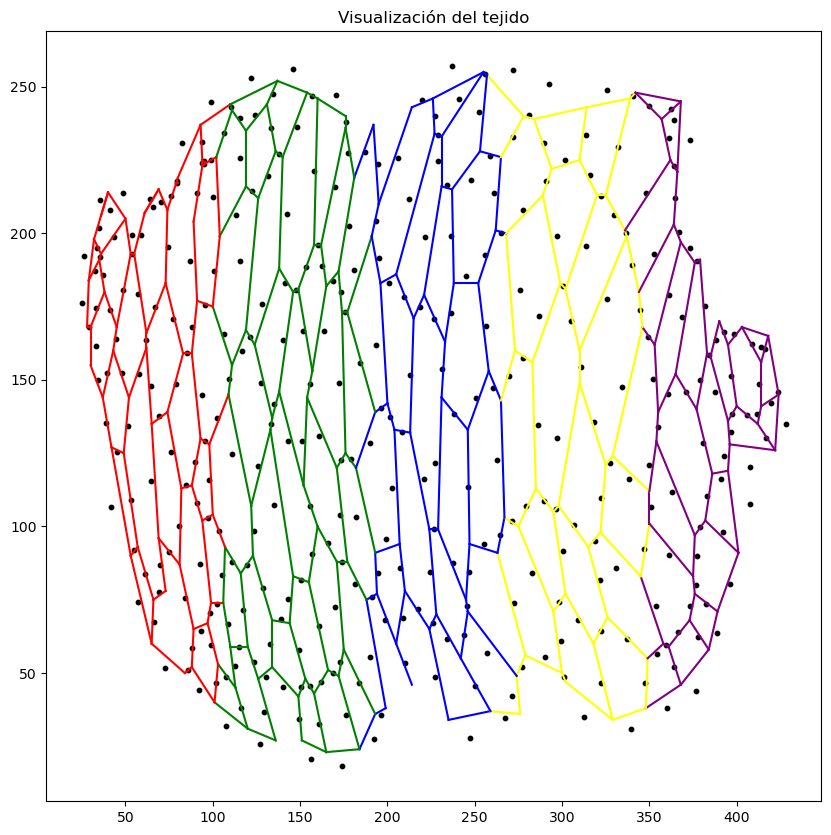

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define el rango de x y el ancho del segmento
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()
segment_width = (max_x - min_x) / 5

# Define los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(6)]

# Asigna cada borde a un segmento
df['Segment'] = pd.cut(df['Mid_X'], bins=seg_boundaries, labels=[1, 2, 3, 4, 5])
df = df.dropna(subset=['Segment'])
# Define los colores para cada segmento
colors = ['red', 'green', 'blue', 'yellow', 'purple']

plt.figure(figsize=(10, 10))

# Dibuja los nodos
plt.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], 
             [row['Y1'], row['Y2']],
             color=colors[int(row['Segment'])-1])

plt.title('Visualización del tejido')
plt.show()


C:\Users\Jon\anaconda3\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


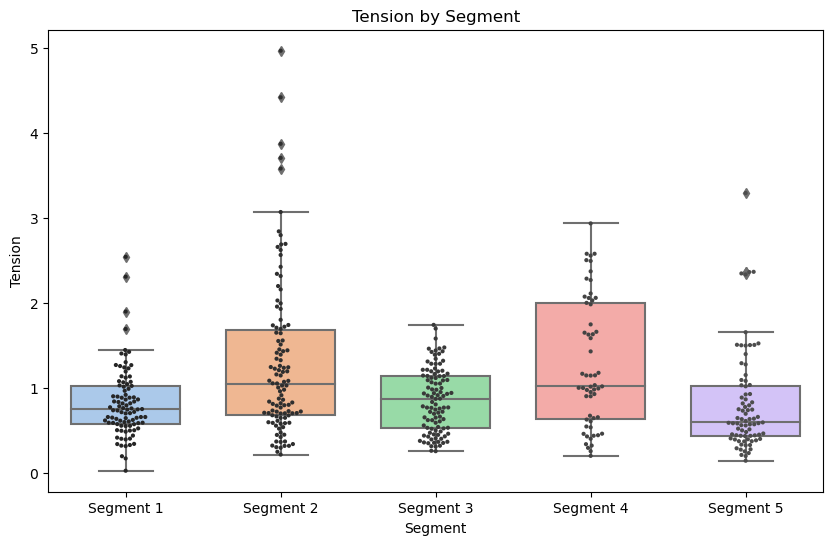

In [6]:
import seaborn as sns

# Crear una lista para almacenar los DataFrames de cada segmento
segment_dfs = []

# Dividir el DataFrame en cinco segmentos basados en la posición X media
for i in range(5):
    df_seg = df[(df['Mid_X'] >= seg_boundaries[i]) & (df['Mid_X'] < seg_boundaries[i+1])].copy()
    # Renombrar la columna de tensión para reflejar el segmento
    segment_name = f'Segment {i+1}'
    df_seg.rename(columns={'Tension': segment_name}, inplace=True)
    segment_dfs.append(df_seg[[segment_name]])

# Concatenar los DataFrames de los segmentos a lo largo del eje de las columnas
df_concat = pd.concat(segment_dfs, axis=1)

# Crear el boxplot con seaborn
plt.figure(figsize=(10,6))
sns.boxplot(data=df_concat, width=0.7, fliersize=5, palette='pastel')

# Añadir los puntos individuales con swarmplot
sns.swarmplot(data=df_concat, size=3, color=".3", linewidth=0)

plt.title('Tension by Segment')
plt.xlabel('Segment')
plt.ylabel('Tension')
plt.show()



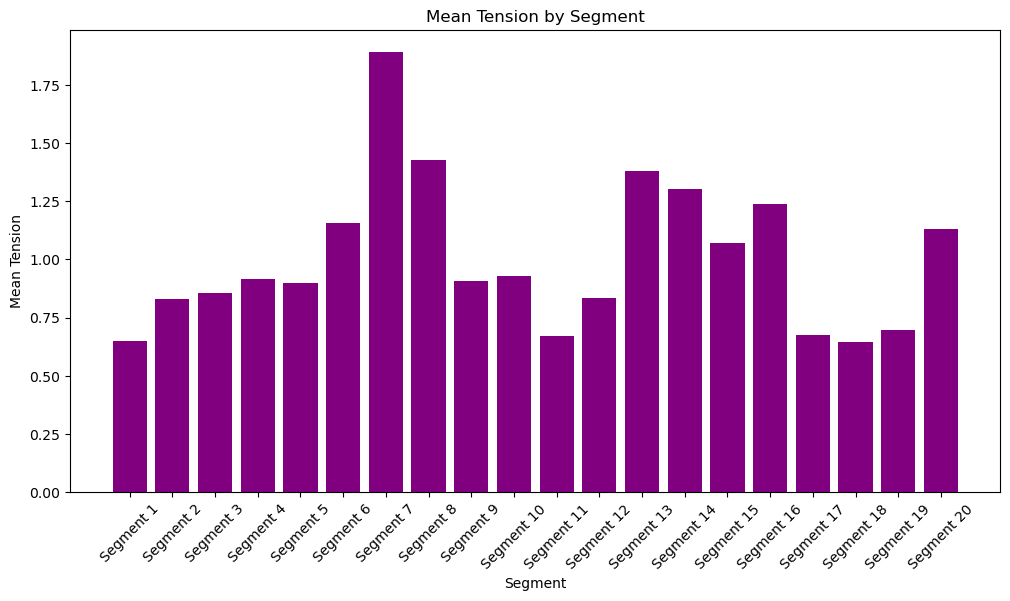

In [7]:
# Identificar el punto más a la izquierda y el más a la derecha usando Mid_X
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()

# Calcular el ancho de cada segmento
segment_width = (max_x - min_x) / 20

# Crear los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(21)]

# Crear una lista para almacenar las medias de tensión de cada segmento
mean_tensions = []

# Dividir el DataFrame en once segmentos basados en la posición X media
for i in range(20):
    df_seg = df[(df['Mid_X'] >= seg_boundaries[i]) & (df['Mid_X'] < seg_boundaries[i+1])]
    # Calcular la tensión promedio para el segmento
    mean_tensions.append(df_seg['Tension'].mean())

# Crear nombres para los segmentos
seg_names = [f'Segment {i+1}' for i in range(20)]

# Crear el gráfico
plt.figure(figsize=(12,6))
plt.bar(seg_names, mean_tensions, color='purple')
plt.xlabel('Segment')
plt.ylabel('Mean Tension')
plt.title('Mean Tension by Segment')
plt.xticks(rotation=45)
plt.show()


In [2]:
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class SelectFromImage(object):
    def __init__(self, ax):
        self.ax = ax
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None
        self.verts = None

    def onselect(self, verts):
        self.verts = verts  # Guardar los vértices seleccionados
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        self.ax.figure.canvas.draw()



# Define el rango de x y el ancho del segmento
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()
segment_width = (max_x - min_x) / 5

# Define los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(6)]

# Asigna cada borde a un segmento
df['Segment'] = pd.cut(df['Mid_X'], bins=seg_boundaries, labels=[1, 2, 3, 4, 5])
df = df.dropna(subset=['Segment'])
# Define los colores para cada segmento
colors = ['red', 'green', 'blue', 'yellow', 'purple']

fig, ax = plt.subplots(figsize=(10, 10))

# Dibuja los nodos
ax.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    ax.plot([row['X1'], row['X2']], 
            [row['Y1'], row['Y2']],
            color=colors[int(row['Segment'])-1])

ax.set_title('Visualización del tejido')

lasso_select = SelectFromImage(ax)
plt.gca().invert_yaxis()
plt.show()


In [3]:
# Crea un objeto Path utilizando los vértices seleccionados
selected_path = Path(lasso_select.verts)

# Crea una nueva columna en tu DataFrame para almacenar si cada edge está dentro o fuera de la región seleccionada
df['In_Selected_Area'] = selected_path.contains_points(df[['Mid_X', 'Mid_Y']].values)

# Ahora, df['In_Selected_Area'] será True para los edges que estén dentro de la región seleccionada y False para los que estén fuera.


In [4]:
print(df)

     EdgeID     X1     Y1     X2     Y2     Length       Mid_X       Mid_Y  \
0         3  179.0    9.0  185.0    6.0   6.708204  181.592203    6.714530   
1         4  185.0    6.0  205.0   10.0  20.396078  195.148164    6.969137   
2         5  185.0    6.0  189.0   27.0  21.377558  185.893894   16.717293   
3         6  205.0   10.0  228.0   13.0  23.194827  216.695184    8.424230   
4         7  205.0   10.0  213.0   35.0  26.248809  207.529009   22.924050   
..      ...    ...    ...    ...    ...        ...         ...         ...   
442     447  257.0  223.0  247.0  209.0  17.204651  253.916206  214.665112   
443     448  229.0  224.0  230.0  220.0   4.123106  229.507328  222.001832   
444     449  279.0  216.0  296.0  227.0  20.248457  281.732993  227.190774   
445     450  279.0  216.0  288.0  214.0   9.219544  283.373115  214.458919   
446     451  296.0  227.0  288.0  214.0  15.264338  292.430036  220.247577   

             Vector       Angle  CELL1  CELL2  Area_CELL1  Area

In [5]:
# Configura el tamaño de la figura para que sea más ancha

# Crea subplots
fig, ax = plt.subplots()

# Ordena los dataframes por tensión
df_inside = df_inside.sort_values('Tension')
df_outside = df_outside.sort_values('Tension')

# Dibuja los puntos para los edges dentro del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_inside)), df_inside['Tension'], yerr=df_inside['stdError'], fmt='o', 
            color='blue', ecolor='black', elinewidth=1, capsize=3, label='Inside')

# Dibuja los puntos para los edges fuera del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_outside)), df_outside['Tension'], yerr=df_outside['stdError'], fmt='o', 
            color='red', ecolor='black', elinewidth=1, capsize=3, label='Outside')

# Añade una leyenda
ax.legend()

# Añade títulos y etiquetas
ax.set_title('Tension of Edges Inside and Outside Selected Area', fontsize=16)
ax.set_xlabel('Edge', fontsize=14)
ax.set_ylabel('Tension', fontsize=14)

# Ajusta el estilo de los ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Hace el eje x más largo
#ax.set_xlim(-1, max(len(df_inside), len(df_outside)))

plt.show()


NameError: name 'df_inside' is not defined

# STRESS

In [115]:
# Let's create a dictionary for cells with EdgeIDs and Area.
cell_dict = {}

for index, row in df.iterrows():
    for cell_number in ['CELL1', 'CELL2']:
        cell_id = row[cell_number]
        if not math.isnan(cell_id):  # Check if cell_id is not NaN
            cell_id = int(cell_id)
            if cell_id in cell_dict:
                cell_dict[cell_id]['edges'].append(row['EdgeID'])
            else:
                cell_dict[cell_id] = {'edges': [row['EdgeID']], 'area': row['Area_' + cell_number]}

# Now we can convert this dictionary into a DataFrame.
cell_df = pd.DataFrame.from_dict(cell_dict, orient='index')
cell_df.index.name = 'CellID'
cell_df.reset_index(inplace=True)

# Initialize two new columns to store the centroid coordinates
cell_df['centroid_x'] = np.nan
cell_df['centroid_y'] = np.nan

# Iterate over each cell
for i, row in cell_df.iterrows():
    edge_ids = row['edges']  # Get the edge IDs of the current cell
    
    # Filter the edges DataFrame to keep only the edges that belong to the current cell
    edges_of_cell = df[df['EdgeID'].isin(edge_ids)]
    
    # Calculate the centroid coordinates as the mean of the nodes coordinates
    centroid_x = edges_of_cell[['X1', 'X2']].mean(axis=1).mean()
    centroid_y = edges_of_cell[['Y1', 'Y2']].mean(axis=1).mean()
    
    # Update the centroid coordinates of the current cell in the cells DataFrame
    cell_df.at[i, 'centroid_x'] = centroid_x
    cell_df.at[i, 'centroid_y'] = centroid_y

print(cell_df)

     CellID                                              edges        area  \
0         1  [3, 4, 6, 8, 10, 12, 14, 15, 17, 19, 20, 25, 2...    0.000000   
1         2                                  [3, 5, 9, 23, 29]  155.138889   
2         3                                  [4, 5, 7, 30, 43]  518.079444   
3         4                                     [6, 7, 11, 44]  432.000000   
4         5                                 [8, 9, 13, 24, 61]  475.060000   
..      ...                                                ...         ...   
147     148                          [433, 434, 435, 436, 437]  565.208333   
148     149                               [438, 439, 440, 444]  345.750000   
149     150                               [441, 442, 443, 444]  247.370000   
150     151                               [445, 446, 447, 448]  325.625000   
151     152                                    [449, 450, 451]  189.137778   

     centroid_x  centroid_y  
0    224.716667      122.35  
1  

In [134]:
def calculate_stress_tensor(cell_id, cell_area, edge_ids, df, total_area, p=0.02):  # Assuming constant pressure p
    stress_tensor = np.zeros((2, 2))
    for edge_id in edge_ids:
        edge = df[df['EdgeID'] == edge_id].iloc[0]
        vector_ij = np.array([edge['X2'] - edge['X1'], edge['Y2'] - edge['Y1']])
        T = edge['Tension']
        stress_tensor += T * np.outer(vector_ij, vector_ij) / np.linalg.norm(vector_ij)
    stress_tensor -= np.abs(p) * cell_area * np.eye(2)
    stress_tensor=stress_tensor/total_area
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    return stress_tensor, eigenvalues, eigenvectors

total_area = cell_df['area'].sum()
# Apply function to each cell
results = []
for index, row in cell_df.iterrows():
    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(row['CellID'], row['area'], row['edges'], df,total_area)
    results.append({
        'CellID': row['CellID'],
        'StressTensor': stress_tensor,
        'Eigenvalues': eigenvalues,
        'Eigenvectors': eigenvectors
    })

# Convert results into a dataframe
results_df = pd.DataFrame(results)
#results_df['NormalizedStressTensor'] = results_df['StressTensor'].apply(lambda x: x / total_area)


In [135]:
print(results_df)

     CellID                                       StressTensor  \
0         1  [[0.008903697764692171, -0.0002857854367244501...   
1         2  [[0.00015046827905194375, -5.285494862485358e-...   
2         3  [[0.0006263804611000985, 0.0002813574183862885...   
3         4  [[0.00046443360430891106, -4.940300478807203e-...   
4         5  [[0.00015252215992420107, -0.00017557119904720...   
..      ...                                                ...   
147     148  [[0.0006044587138102976, 0.000169000269978156]...   
148     149  [[0.00021396235601231717, 8.809726806659074e-0...   
149     150  [[0.00016588465926867458, -6.430565384865861e-...   
150     151  [[0.0002446560879960829, -8.278386419813607e-0...   
151     152  [[0.00036608847354945457, 0.000256723664141649...   

                                          Eigenvalues  \
0        [0.008920276399117012, 0.003977277786373034]   
1    [0.00013507932183681672, 0.00033200400984140954]   
2     [0.0008003428040402349, 0.0001

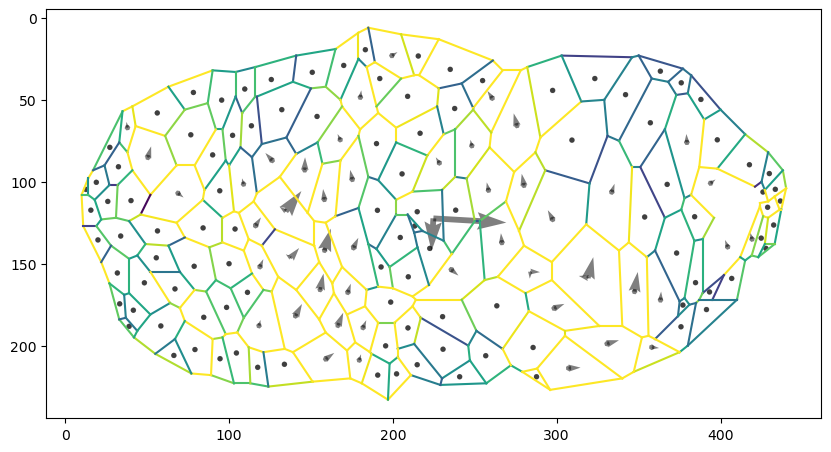

In [136]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
# Plotting the edges for each cell
# Draw each edge
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], [row['Y1'], row['Y2']], color=plt.cm.viridis(row['Tension']))

# Add a color bar to show the scale of tension
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['Tension'].min(), vmax=df['Tension'].max()))
#plt.colorbar(sm)
# Plot each cell's stress vector
for _, cell in cell_df.iterrows():
    cell_id = cell['CellID']
    result_row = results_df[results_df['CellID'] == cell_id].iloc[0]

    # Get eigenvectors and eigenvalues
    eigenvectors = np.array(result_row['Eigenvectors'])
    eigenvalues = np.array(result_row['Eigenvalues'])
    #stress_vectors=np.array(result_row['NormalizedStressTensor'])
    
    # Calculate the stress vectors
    stress_vectors = eigenvectors * eigenvalues[:, np.newaxis]*5000
    
    # There are two stress vectors per cell, let's plot them both
    for vector in stress_vectors:
        ax.quiver(cell['centroid_x'], cell['centroid_y'], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, alpha=0.5)

ax.set_aspect('equal')  # Equal scaling in both axis
plt.gca().invert_yaxis()
plt.show()


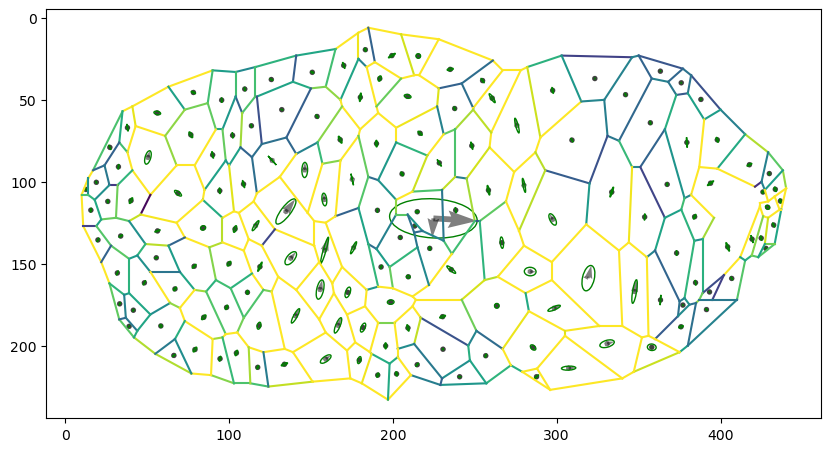

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar cada arista
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], [row['Y1'], row['Y2']], color=plt.cm.viridis(row['Tension']))

# Añadir una barra de color para mostrar la escala de tensión
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['Tension'].min(), vmax=df['Tension'].max()))
#plt.colorbar(sm)

# Dibujar el vector de estrés de cada célula y la elipse correspondiente
for _, cell in cell_df.iterrows():
    cell_id = cell['CellID']
    result_row = results_df[results_df['CellID'] == cell_id].iloc[0]

    # Obtener los eigenvectores y los eigenvalores
    eigenvectors = np.array(result_row['Eigenvectors'])
    eigenvalues = np.array(result_row['Eigenvalues'])
    
    # Calcular los vectores de tensión
    stress_vectors = eigenvectors * eigenvalues[:, np.newaxis]*3000
    
    # Hay dos vectores de tensión por célula, vamos a dibujarlos ambos
    for vector in stress_vectors:
        ax.quiver(cell['centroid_x'], cell['centroid_y'], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, alpha=0.5)
    
    # Obtener el índice del vector más grande y el más pequeño
    max_vector_index = np.argmax(eigenvalues)
    min_vector_index = np.argmin(eigenvalues)
    
    # Calcular los ángulos de los eigenvectores
    angles = np.arctan2(eigenvectors[:, 1], eigenvectors[:, 0])

    # Crear una elipse con los eigenvalores como longitud de los ejes y los ángulos de los eigenvectores como orientación
    ellipse = Ellipse((cell['centroid_x'], cell['centroid_y']), 
                      width=eigenvalues[max_vector_index]*6000, 
                      height=eigenvalues[min_vector_index]*6000, 
                      angle=np.degrees(angles[max_vector_index]), 
                      fill=False, 
                      color='green')

    ax.add_patch(ellipse)

ax.set_aspect('equal')  # Escala igual en ambos ejes
plt.gca().invert_yaxis()
plt.show()
